HHU Deep Learning in Life Science: Generative Models, Prof. Dr. **Markus Kollmann**, WS 2025-2026

Tutors: **Felix Michels** and **Adaloglou Nikolaos**
## Assignment 3 - Normalizing Flows

- **Submission  [link](https://uni-duesseldorf.sciebo.de/s/NqbriCZ38cQkW45)**
- **Deadline**: 04/12/2025 14:30 CET (2-week exercise)
- **Note**: `Rename` your file BEFORE submitting!
- If you encounter issues that might apply to other students, please notify others in the group chat.

#### How to submit
- Submit the solved notebook (not a zip) with your full name (`NAME_SURNAME`) plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for `assignment 1`. If you have more names, please use only the first one for all homeworks.
- Please use the same naming convention `NAME_SURNAME_aX` to facilitate the tutors.
- You are free to modify our code as you see fit.
---

This exercise is about implementing the Normalizing Flow model (NF) [[1](https://arxiv.org/pdf/1505.05770v6.pdf), [2](https://lilianweng.github.io/posts/2018-10-13-flow-models/)] model. 

The idea of *Normalizing Flows* (NF)  has been introduced to address the problem of optimizing the probability distribution of a given set of data. 

The main idea is to start from a simple probability distribution and approximate a complex **multimodal density by transforming the simpler density through a sequence of invertible nonlinear transforms**. 

This allows us to rely on distributions of arbitrary complexity and also learn the parameters of these transforms depending on some conditions.

### Table of Contents

The notebook contains of the following sections:

1. Introduction to Pytorch [Distributions](https://pytorch.org/docs/stable/distributions.html?highlight=distributions#module-torch.distributions) module and how to use it.
2. Chaining Transforms (Normalizing Flows)
3. Implementing a Planar Flow
4. Applying a Planar Flow to a Multivariate Normal Distribution
5. Defining a Planar Flow Module
6. Toy Model Setup
7. Training and Sampling
8. Normalizing FLow Models in Practice
9. Implementing Affine Coupling Layers
10. Training on MNIST

<a id="distribs"></a>
## Part I. Introduction to Pytorch Distributions

In this tutorial, we are going to rely on [PyTorch distributions module](https://pytorch.org/docs/stable/distributions.html?highlight=distributions#module-torch.distributions), which is defined in `torch.distributions`. Most notably, we are going to rely both on the `Distribution` and `Transform` objects.

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
from torch import distributions as distrib
from torch.distributions import transforms
from torch import optim

# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [3]:
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

Inside this toolbox, we find some of the major probability distributions that are commonly used, like `Normal`, `Bernoulli`, `Beta`, `Gamma` and `Pareto`.

A useful property of these `Distribution` objects is that we can obtain both samples from it (through the `sample` method) and the analytical density at any given point through the `log_prob` class method.

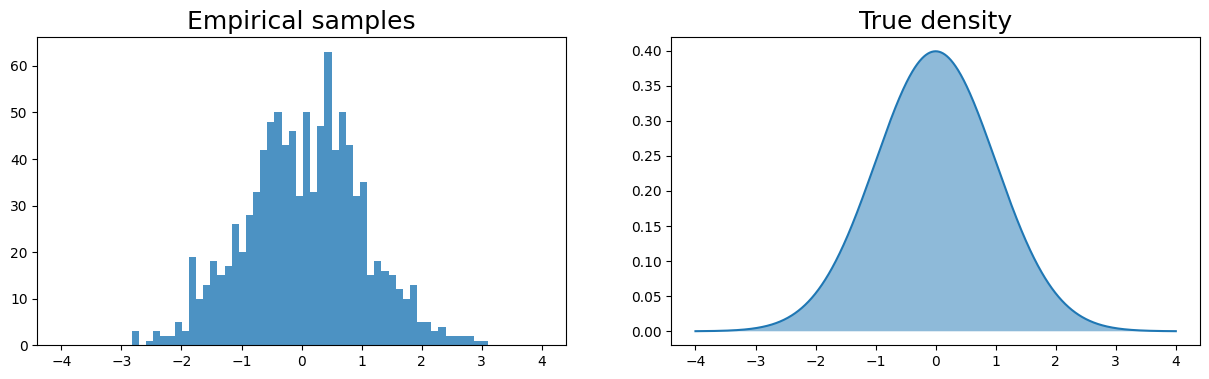

In [4]:
# Based on a normal
n = distrib.Normal(0, 1)
# Obtain some samples
samples = n.sample((1000,))
# Evaluate true density at given points
density = torch.exp(n.log_prob(torch.from_numpy(x))).numpy()

# Plot both samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples, 50, alpha=0.8)
ax1.set_title("Empirical samples", fontsize=18)
ax2.plot(x, density)
ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title("True density", fontsize=18);

Expected results:

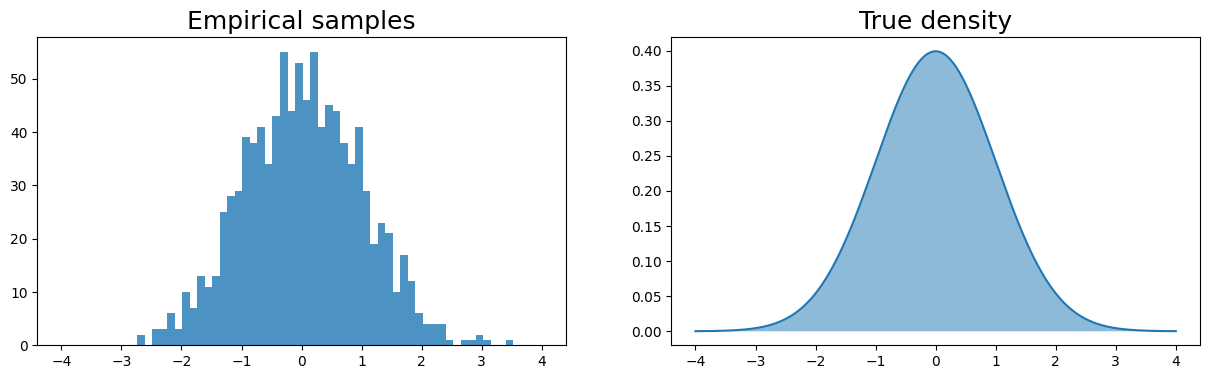



<a id="change"></a>
## Transforming distributions

### Change of variables and flow

In order to transform a probability distribution, we can perform a *change of variable*. This term can refer to different applications, typically to regular functions in analysis (integration by substitution), however, here we are interested in probability distributions. Formally, the change of variables formula for probability density functions looks like this:

Let $\mathbf{z}$ be a random variable with values in $\mathbb{R}^d$ with probability density function $q_0(\mathbf{z})$
and let $f:\mathbb{R}^d\rightarrow\mathbb{R}^d$ be an invertible smooth mapping (meaning that $f^{-1}$ exists with $(f^{-1}\circ f)(\mathbf{z})=(f\circ f^{-1})(\mathbf{z})) = \mathbf{z}$ for all $\mathbf{z}$ and that $f$, $f^{-1}$ and their derivatives are continuous).
We can use $f$ to transform $\mathbf{z}\sim q_0(\mathbf{z})$ to a random variable $\mathbf{z}'=f(\mathbf{z})$ which has the following probability density function
$$
q_1(\mathbf{z}')=q_0(\mathbf{z})\left|\det\frac{\partial f^{-1}}{\partial \mathbf{z}'}\right| = q_0(f^{-1}(\mathbf{z}'))\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|^{-1},
\tag{1}
$$
where the last equality is obtained through the inverse function theorem [1]. 

In this setting, the correction term introduced by the change in variable *scales* our transformed density so that the total probability still sums to one (*volume preserving*). This is directly measured by the inverse of the absolute value of the determinant of our transform (if you need more intuitive examples, you can check the great [Eric Jang's tutorial](https://blog.evjang.com/2018/01/nf1.html)). Hence, we can transform a probability distribution by using an invertible mapping and normalize it using the determinant of this mapping. 

Fortunately, this can be easily implemented in PyTorch with the `Transform` classes, that already defines some basic probability distribution transforms. For instance, if we define $\mathbf{z}\sim q_0(\mathbf{z})=\mathcal{N}(0, 1)$, we can apply the transform $\mathbf{z}'=\exp(\mathbf{z})$ so that $\mathbf{z}'\sim q_1(\mathbf{z}')$.


In Pytorch this can be implemented as follows:
```
transformed_dist = distrib.TransformedDistribution(base_dist, transforms)
```

`distrib.TransformedDistribution` applies a sequence of Transforms to a base distribution. Let f be the composition of transforms applied:

```
X ~ BaseDistribution
Y = f(X) ~ TransformedDistribution(BaseDistribution, f)
log p(Y) = log p(X) + log |det (dX/dY)|
```

### Task: 

Produce two plots with 1000 empirical samples each for:

* $q_0 \sim \mathcal{N}(0,1)$
* $q_1 = \exp(q_0)$

To perform the transformation, use `transforms.ExpTransform()`.

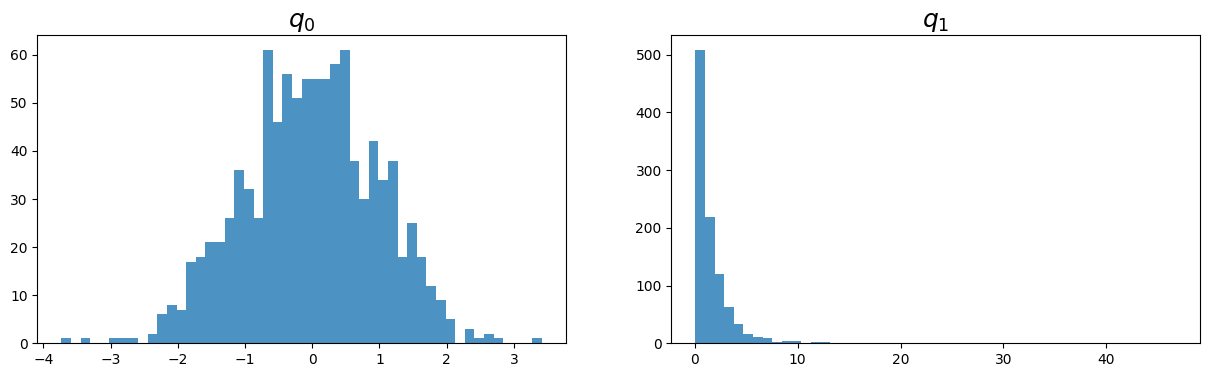

In [5]:
### START CODE HERE ###
base_dist = distrib.Normal(0, 1)
transform = transforms.ExpTransform()
transformed_dist = distrib.TransformedDistribution(base_dist, transform)

samples_base = base_dist.sample((1000,))
samples_transformed = transformed_dist.sample((1000,))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.hist(samples_base.numpy(), bins=50, alpha=0.8)
ax1.set_title("$q_0$", fontsize=18)

ax2.hist(samples_transformed.numpy(), bins=50, alpha=0.8)
ax2.set_title("$q_1$", fontsize=18)

plt.show()
### END CODE HERE ###

Expected results:

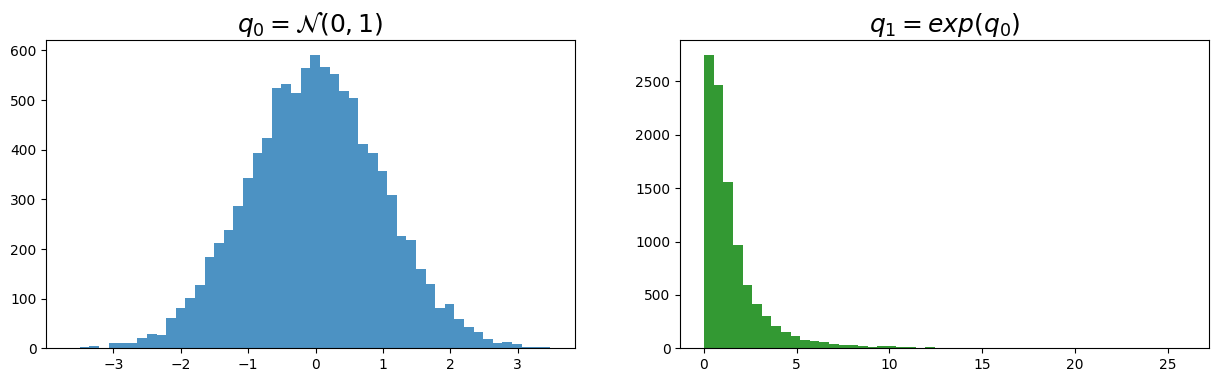



But remember as the objects `q0` and `q1` are defined as `Distribution`, we can actually observe their true densities instead of just empirical samples.

## Task

Produce another two plots, this time with the true density functions of $q_0$ and $q_1$.

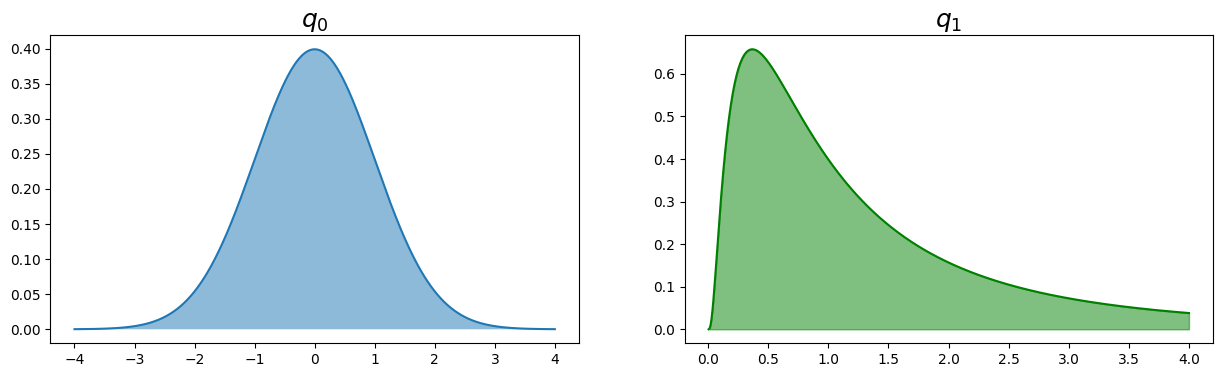

In [6]:
### START CODE HERE ###
x_positive = x[x > 0]

density_base = torch.exp(base_dist.log_prob(torch.from_numpy(x))).numpy()
density_transformed = torch.exp(transformed_dist.log_prob(torch.from_numpy(x_positive))).numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(x, density_base)
ax1.fill_between(x, density_base, 0, alpha=0.5)
ax1.set_title("$q_0$", fontsize=18)

ax2.plot(x_positive, density_transformed, color='green')
ax2.fill_between(x_positive, density_transformed, 0, alpha=0.5, color='green')
ax2.set_title("$q_1$", fontsize=18)

plt.show()
### END CODE HERE ###

Expected results:

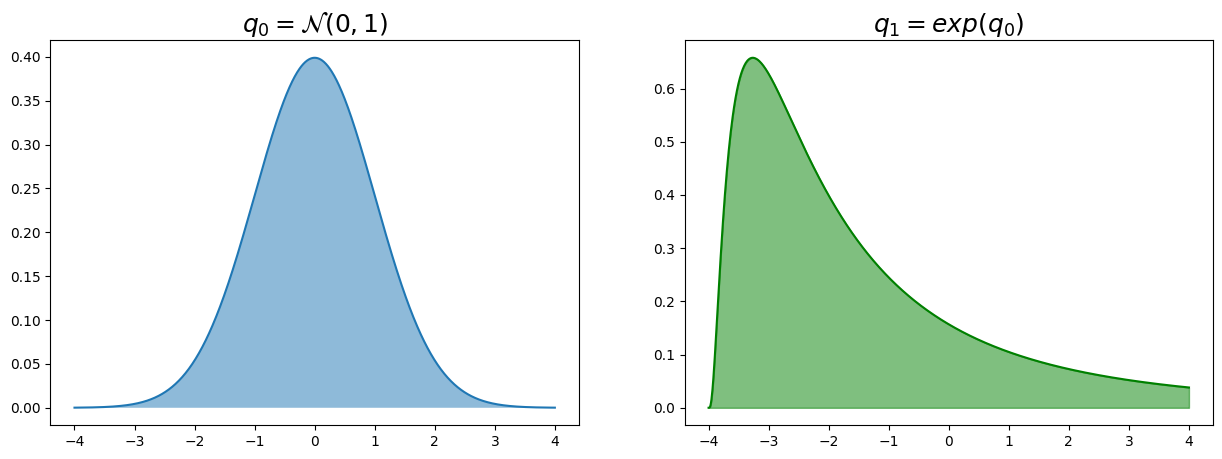



What we obtain here with `q1` is actually the `LogNormal` distribution. You can convince yourself of that by lurking in the code of the [`torch.distributions.LogNormal`](https://pytorch.org/docs/stable/_modules/torch/distributions/log_normal.html#LogNormal).

<a id="chaining"></a>
## Part II. Chaining Transforms (Normalizing Flows)

Now, if we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathbb{N}$ and obtain a normalizing flow. Hence, if we apply $k$ normalizing flows, we obtain a chain of change of variables

$$
\mathbf{z}_k=f_k\circ f_{k-1}\circ...\circ f_1(\mathbf{z}_0)
\tag{2}
$$

Therefore the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ will be given by
   
   $$
   \begin{align}
   q_k(\mathbf{z}_k) &= q_0(f_1^{-1} \circ f_{2}^{-1} \circ ... \circ f_k^{-1}(\mathbf{z}_k))\prod_{i=1}^k\left|\det\frac{\partial f^{-1}_i}{\partial\mathbf{z}_{i}}\right|\\
   &= q_0(\mathbf{z_0})\prod_{i=1}^k\left|\det\frac{\partial f_i}{\partial\mathbf{z}_{i-1}}\right|^{-1}
   \end{align}
   \tag{3}
   $$
    
where we compute the determinant of the Jacobian of each normalizing flow (as explained in the previous section). 

With a series of multiple transformations we can transform a simple probability distribution (e.g. Gaussian) into a complicated multi-modal one. 

As usual, we will rely on log-probabilities to simplify the computation and obtain:

$$
\log q_k(\mathbf{z}_k) = \log q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \log \left|\det\frac{\partial f_i}{\partial\mathbf{z}_{i-1}}\right|
\tag{4}
$$


To be of practical use, however, we can consider only transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations, and it also works with multivariate distributions. Here, this is demonstrated by transforming a `MultivariateNormal` successively with an `ExpTransform` and `AffineTransform`. (Note that the final distribution `q2` is defined as a `TransformedDistribution` directly with a *sequence* of transformations)

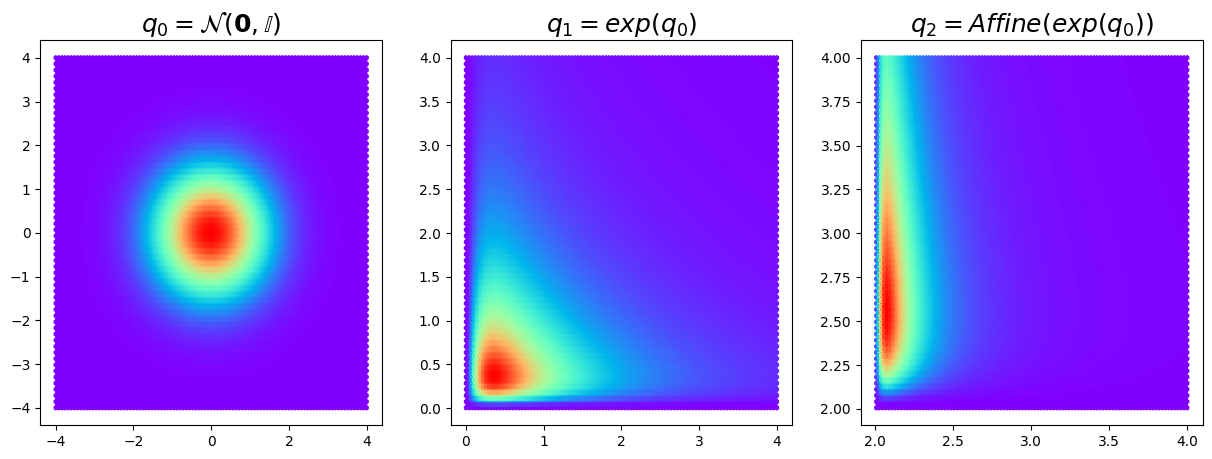

In [7]:
x1 = np.linspace(-4, 4, 1000)
x2 = np.linspace(-4, 4, 1000)
x3 = np.linspace(-4, 4, 1000)

z1 = np.array(np.meshgrid(x1, x1)).transpose(1, 2, 0).reshape(-1, 2)
z2 = np.array(np.meshgrid(x2, x2)).transpose(1, 2, 0).reshape(-1, 2)
z3 = np.array(np.meshgrid(x3, x3)).transpose(1, 2, 0).reshape(-1, 2)

q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2), validate_args=False)
# Define an exp transform
f1 = transforms.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1, validate_args=False)
# Define an additional affine transform
f2 = transforms.AffineTransform(2, torch.Tensor([0.2, 1.5]))
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2], validate_args=False)
# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:, 0], z[:, 1], C=q0.log_prob(torch.Tensor(z1)).exp(), cmap="rainbow")
ax1.set_title(r"$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$", fontsize=18)
ax2.hexbin(z[:, 0], z[:, 1], C=q1.log_prob(torch.Tensor(z2)).exp(), cmap="rainbow")
ax2.set_title(r"$q_1=exp(q_0)$", fontsize=18)
ax3.hexbin(z[:, 0], z[:, 1], C=torch.exp(q2.log_prob(torch.Tensor(z3))), cmap="rainbow")
ax3.set_title(r"$q_2=Affine(exp(q_0))$", fontsize=18);

Expected results:

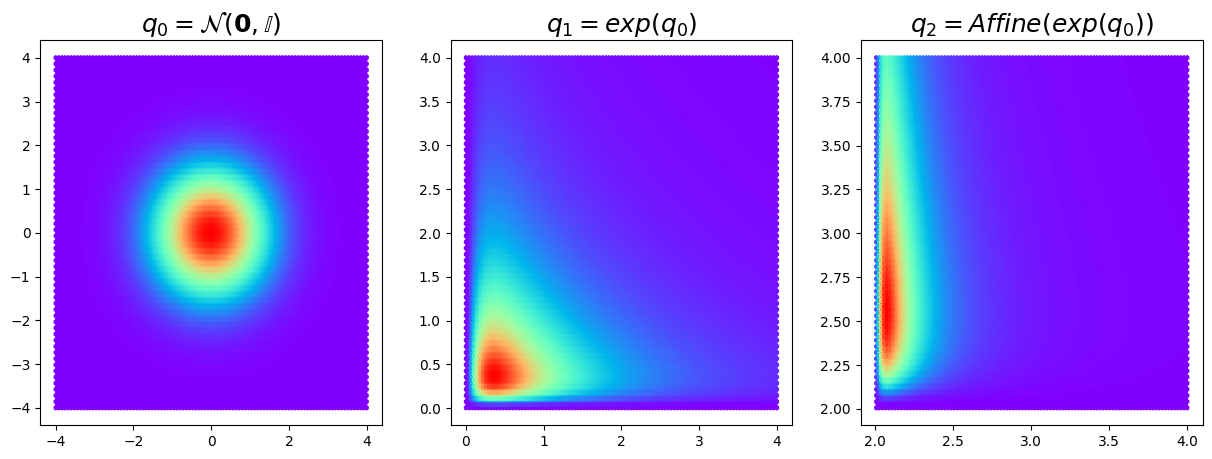



Make sure you understand what's going on in the plots above. 

## Question

* Explain the plots for $q_1$ and $q_2$. Why do they look the way they do, based on $q_0$? 

## Answer

* ...

<a id="planar"></a>
## Part III: Implementing a Planar Flow

Now, we will define our own "flows". We will implement the *planar flow* proposed in the original paper by Rezende [1].

### Planar flow

 A planar normalizing flow is defined as a function of the form

   $$
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^\intercal\mathbf{z}+b), 
   \tag{5}
   $$

   where $\mathbf{u}\in\mathbb{R}^D$ and $\mathbf{w}\in\mathbb{R}^D$ are vectors (called here scale and weight), $b\in\mathbb{R}$ is a scalar (bias) and $h$ is an activation function. These transform functions are chosen depending on the fact that
1. the determinant of their Jacobian can be computed in linear time
2. the transformation is invertible (under mild conditions only)
   
As shown in the paper, for the planar flow, the determinant of the Jacobian can be computed in $O(D)$ time by relying on the matrix determinant lemma

$$
\psi(\mathbf{z}) \coloneqq h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
\tag{6}
$$

$$
\left|\text{det}\frac{\partial f}{\partial\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
\tag{7}
$$

Therefore, we have all definitions that we need to implement this flow as a `Transform` object. Note that here the non-linear activation function $h$ is selected as a $\tanh$. Therefore the derivative $h'$ is $1-\tanh(x)^2$

## Task

Implement the `PlanarFlow` class below. Don't forget to add a small constant (`eps`) to the |det| at the end to avoid numerical issues. 

In [8]:
class PlanarFlow(transforms.Transform):
    def __init__(
        self, weight: Tensor, scale: Tensor, bias: float | Tensor, eps: float = 1e-8
    ):
        super().__init__()
        self.domain = torch.distributions.constraints.real
        self.codomain = torch.distributions.constraints.real
        # Define parameters
        self.eps = eps
        self.weight = weight
        self.scale = scale
        self.bias = bias

    def _call(self, z: Tensor) -> Tensor:
        """Forward transformation of the planar flow,
        i.e., f(z)
        """
        # Implement equation 5
        ### START CODE HERE ###
        activation = torch.tanh(torch.matmul(z, self.weight.T) + self.bias) 
        return z + self.scale * activation.unsqueeze(-1)  
        ### END CODE HERE ###

    def log_abs_det_jacobian(self, z: Tensor) -> Tensor:
        """Log absolute determinant of the Jacobian of the planar flow,
        i.e., log|det(df/dz)|
        """
        # Implement equation 7
        ### START CODE HERE ###
        wzb = z @ self.weight + self.bias  
        h_prime = 1 - torch.tanh(wzb) ** 2 
        psi = h_prime.unsqueeze(-1) * self.weight  
        det_jacobian = 1 + psi @ self.scale  
        return torch.log(torch.abs(det_jacobian) + self.eps)
        ### END CODE HERE ###

## Part IV. Applying a Planar Flow to a Multivariate Normal Distribution

A planar flow is a parameterized mapping between distributions. For this section, we will provide values for the parameters, next week we will implement a trainable planar flow. 

Use the following parameters for your planar flow:
```
w = [3., 0]
u = [2., 0]
b = [0]
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
```

Then: 
* Define $q_0$ as a Multivariate Normal distribution with mean (0,0) and stanard deviation $I$.
* Apply the Planar Flow to q0
* Draw 1e6 samples from the new distribution q1
* Plot q0 and q1 in the ranges (-4,4) for both axes (you can use the density for $q_0$ instead of samples)

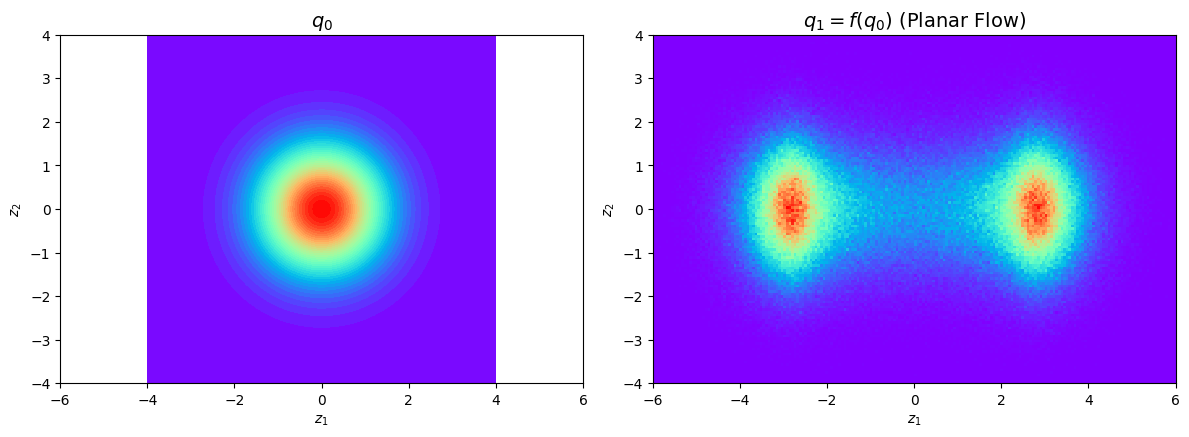

In [48]:
### START CODE HERE ###
q_0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))

w = torch.tensor([3., 0])
u = torch.tensor([2., 0])
b = torch.tensor([0.])
planarflow = PlanarFlow(weight=w, scale=u, bias=b)
q_1 = distrib.TransformedDistribution(q_0, planarflow)

samples_q1 = q_1.sample((1000000,))

x_range = np.linspace(-4, 4, 200)
y_range = np.linspace(-4, 4, 200)
xx, yy = np.meshgrid(x_range, y_range)
grid = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32)

density_q0 = torch.exp(q_0.log_prob(grid)).numpy().reshape(xx.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].contourf(xx, yy, density_q0, levels=50, cmap='rainbow')
axes[0].set_xlim(-6, 6)
axes[0].set_ylim(-4, 4)
axes[0].set_title(r'$q_0$', fontsize=14)
axes[0].set_xlabel('$z_1$')
axes[0].set_ylabel('$z_2$')
axes[0].set_aspect('equal')

axes[1].hist2d(samples_q1[:, 0].numpy(), samples_q1[:, 1].numpy(), 
               bins=200, range=[[-6, 6], [-6, 6]], cmap='rainbow', density=True)
axes[1].set_xlim(-6, 6)
axes[1].set_ylim(-4, 4)
axes[1].set_title(r'$q_1 = f(q_0)$ (Planar Flow)', fontsize=14)
axes[1].set_xlabel('$z_1$')
axes[1].set_ylabel('$z_2$')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()
### END CODE HERE ###

Expected results:

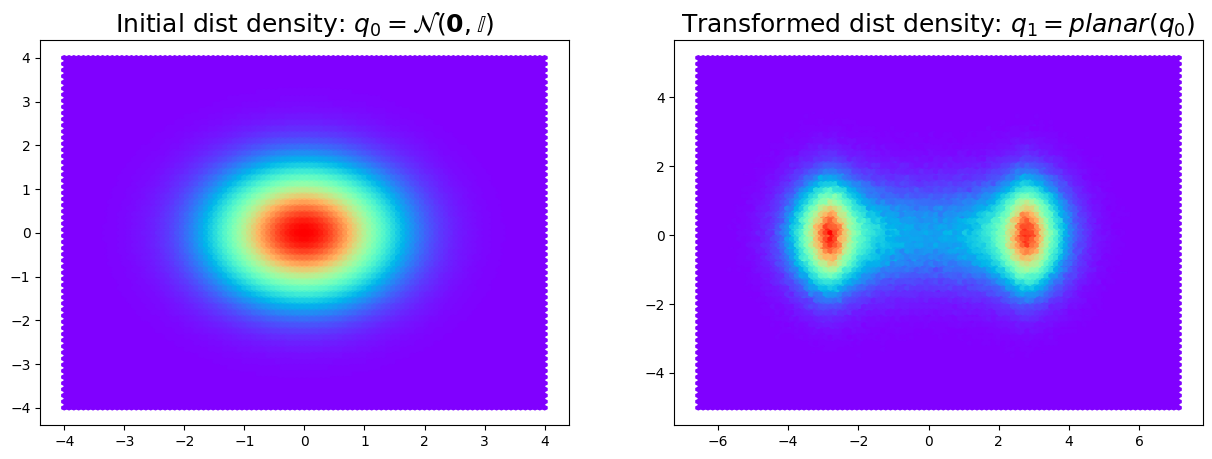



Now, since $q_1$ is an invertible mapping, we can also compute its density function using equation (3). Do so and plot $q_0$ and $q_1$ via their density functions below.

If you already used the density to plot $q_0$ above, its the same plot here again.

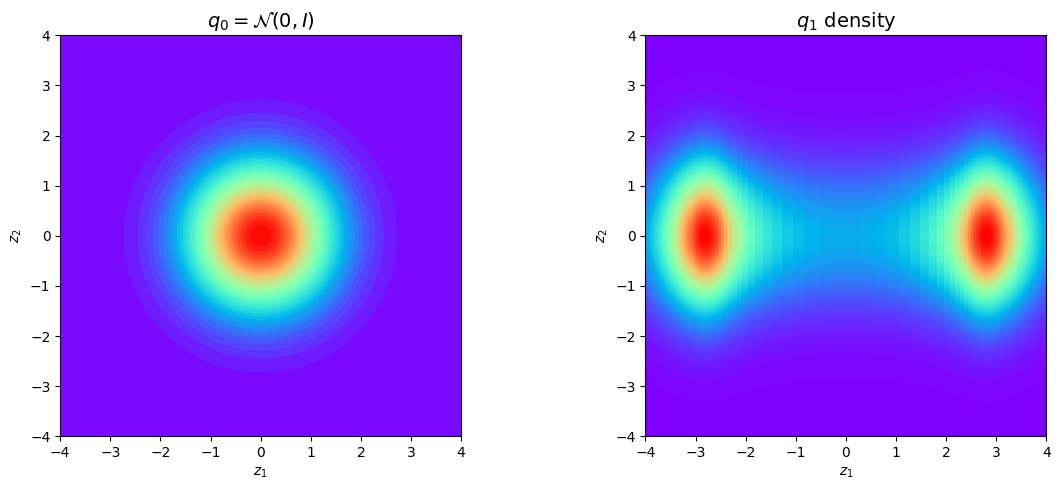

In [10]:
### START CODE HERE ###


x_range = np.linspace(-4, 4, 200)
y_range = np.linspace(-4, 4, 200)
xx, yy = np.meshgrid(x_range, y_range)
grid = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32)

log_prob_q0 = q_0.log_prob(grid)
density_q0 = torch.exp(log_prob_q0).numpy().reshape(xx.shape)

z_transformed = planarflow(grid) 
log_det_jacobian = planarflow.log_abs_det_jacobian(grid) 

log_prob_q1 = log_prob_q0 - log_det_jacobian
density_q1 = torch.exp(log_prob_q1).numpy().reshape(xx.shape)

z_transformed_np = z_transformed.detach().numpy()
xx_transformed = z_transformed_np[:, 0].reshape(xx.shape)
yy_transformed = z_transformed_np[:, 1].reshape(yy.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].contourf(xx, yy, density_q0, levels=50, cmap='rainbow')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_title(r'$q_0 = \mathcal{N}(0, I)$', fontsize=14)
axes[0].set_xlabel('$z_1$')
axes[0].set_ylabel('$z_2$')
axes[0].set_aspect('equal')

axes[1].pcolormesh(xx_transformed, yy_transformed, density_q1, cmap='rainbow', shading='auto')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_title(r'$q_1$ density', fontsize=14)
axes[1].set_xlabel('$z_1$')
axes[1].set_ylabel('$z_2$')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()
### END CODE HERE ###

Expected results:

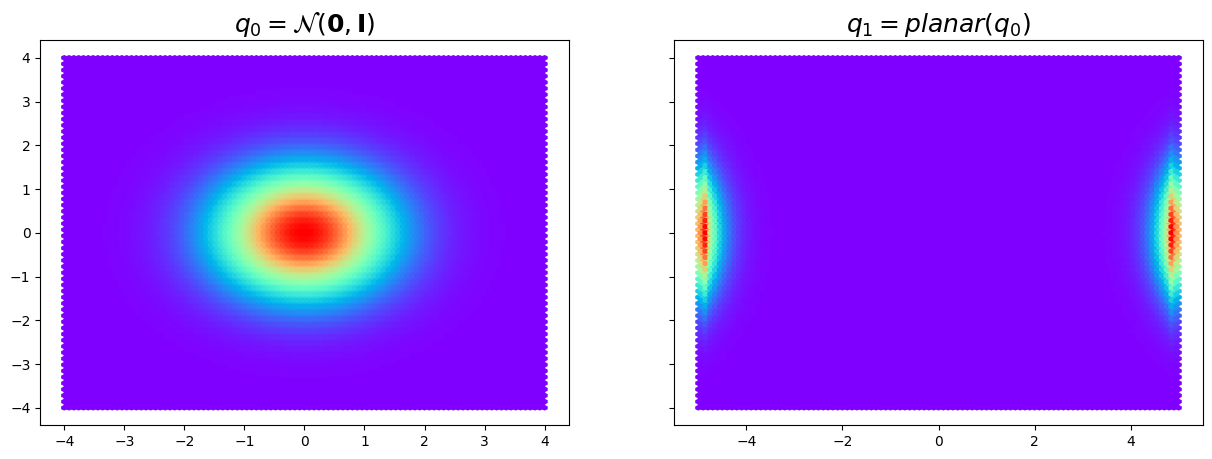



So we were able to "split" our distribution and transform a unimodal gaussian into a multimodal distribution! Pretty neat 

### Visualizing parameters effects

Here, we provide a little toy example so that you can play around with the parameters of the flow in order to get a better understanding of how it operates. As put forward by Rezende [1], this flow is related to the hyperplane defined by $\mathbf{w}^{T}\mathbf{z}+b=0$ and transforms the original density by applying a series of contractions and expansions in the direction perpendicular to this hyperplane.


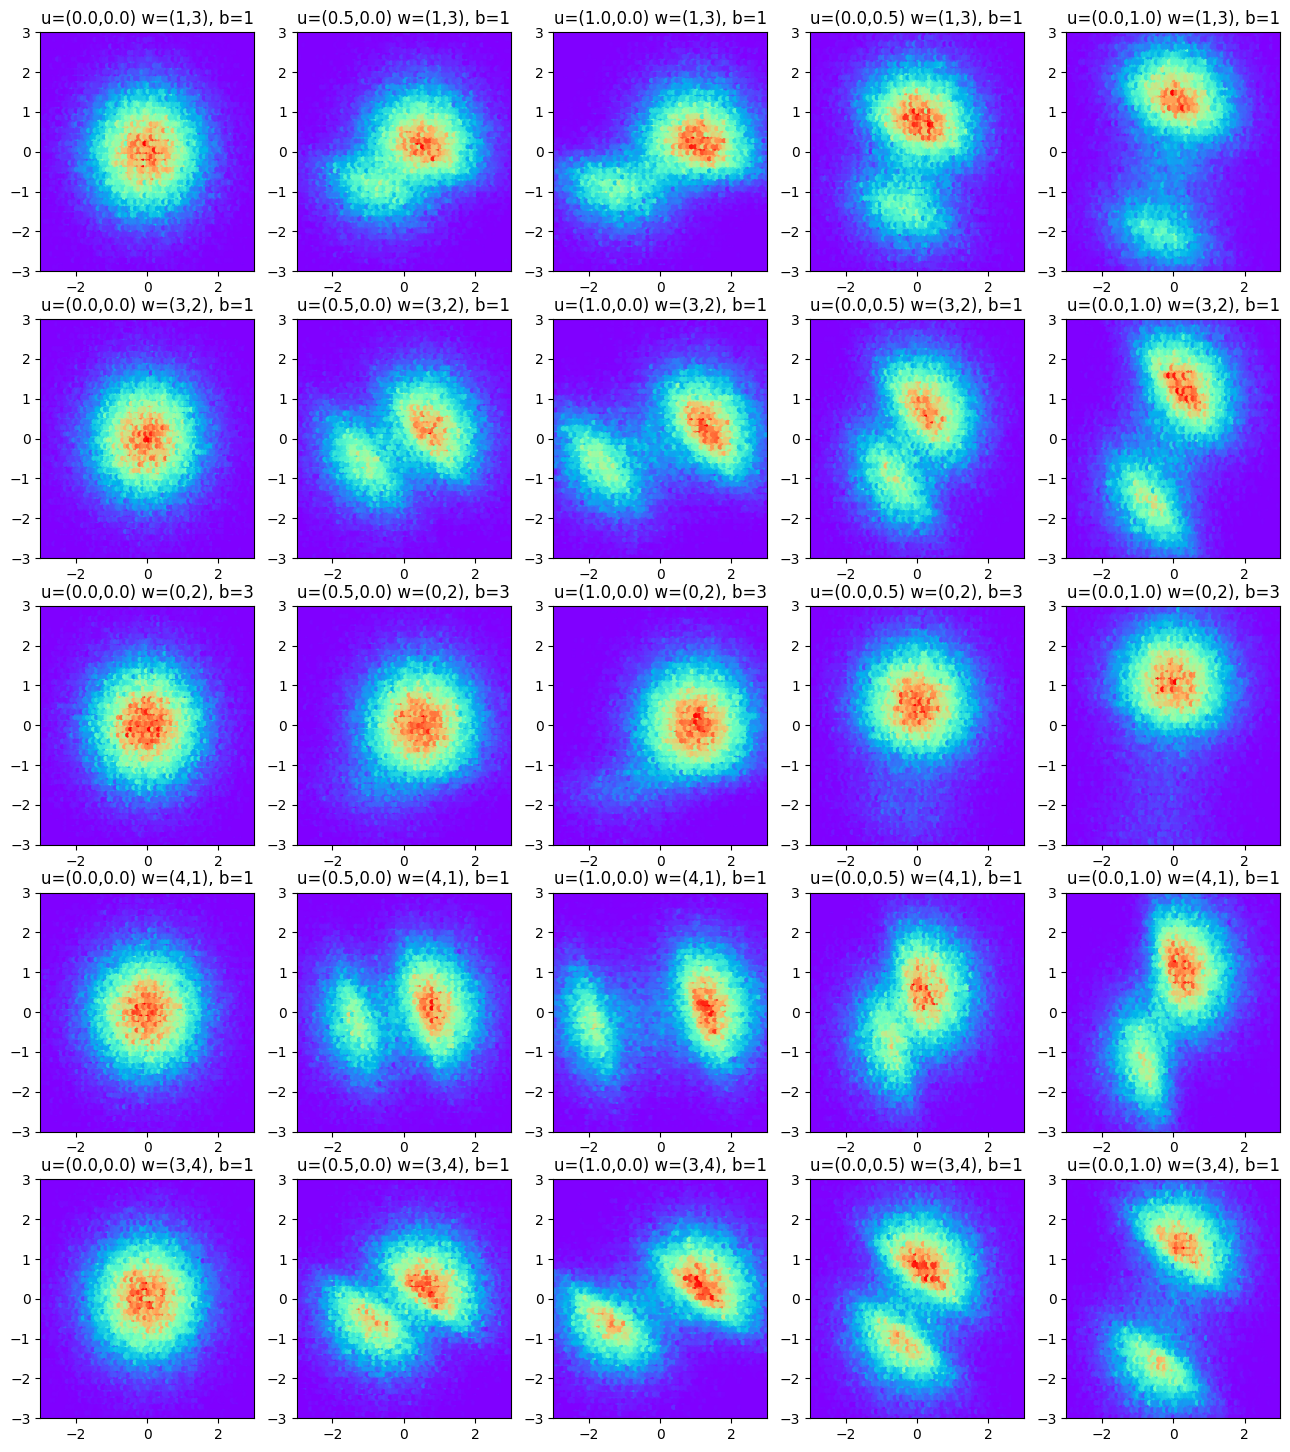

In [24]:
id_figure = 1
plt.figure(figsize=(16, 18))
for i in range(5):
    # Draw a random hyperplane
    w = torch.rand(2) * 5
    b = torch.rand(1) * 5
    for j in np.arange(5):
        # Different effects of scaling factor u on the same hyperplane (row)
        u = torch.asarray(
            [((j < 3) and (j / 2.0) or 0), ((j > 2) and ((j - 2) / 2.0) or 0)]
        )
        flow_0 = PlanarFlow(w, u, b)
        q1 = distrib.TransformedDistribution(q0, flow_0)
        q1_samples = q1.sample((100_000,))
        plt.subplot(5, 5, id_figure)
        plt.hexbin(q1_samples[:, 0], q1_samples[:, 1].numpy(), cmap="rainbow")
        plt.title(
            "u=(%.1f,%.1f)" % (u[0], u[1])
            + " w=(%d,%d)" % (w[0], w[1])
            + ", "
            + "b=%d" % b
        )
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        id_figure += 1

<a id="learning"></a>
## Part V. Defining a Planar Flow Module

We examined chains of planar flows with fixed parameters, now we want to optimize a chain of planar flows in order to learn richer distributions and perform *inference*. We have to deal with the fact that the `Transform` object is not inherently parametric and cannot yet be optimized similarly to other modules.

To do so, we will start by defining our own `FlowModule` class which can be seen both as a `transforms.Transform` and also a `nn.Module` that can be optimized.

In [14]:
class FlowModule(transforms.Transform, nn.Module):
    def __init__(self):
        super().__init__()
        self.domain = torch.distributions.constraints.real
        self.codomain = torch.distributions.constraints.real

    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Thanks to this little trick, we can use the same `PlanarFlow` class as before, that we put back here just to show that the only change is that it now inherits from the `FlowModule` class (with the small added bonus that now parameters of this flow are also registered in the `Module` interface)

In [15]:
class PlanarFlowModule(PlanarFlow, FlowModule):
    def __init__(self, dim: int):
        FlowModule.__init__(self)
        # Define parameters here. They need to be `nn.Parameter`
        ### START CODE HERE ###
        weight = nn.Parameter(torch.randn(dim))
        scale = nn.Parameter(torch.randn(dim))
        bias = nn.Parameter(torch.zeros(1))
        ### END CODE HERE ###

        PlanarFlow.__init__(self, weight, scale, bias)
        self.init_parameters()

    def forward(self, z: Tensor) -> tuple[Tensor, Tensor]:
        """Forward transformation of the planar flow
        Args:
            z: input tensor of shape (batch_size, dim)
        Returns:
            f_out: transformed tensor of shape (batch_size, dim)
            abs_det_grad: log absolute determinant of the Jacobian, shape (batch_size,)
        """
        # You can reuse `_call` and `log_abs_det_jacobian` methods from PlanarFlow,
        # or re-implement them here to avoid unnecessary recomputation
        ### START CODE HERE ###
        f_out = self._call(z)
        log_abs_det_jacobian = self.log_abs_det_jacobian(z)
        return f_out, log_abs_det_jacobian
        ### END CODE HERE ###

## Part VI. Toy Model  Setup

Now let's say that we have a given complex density that we aim to model through normalizing flows, such as the following one

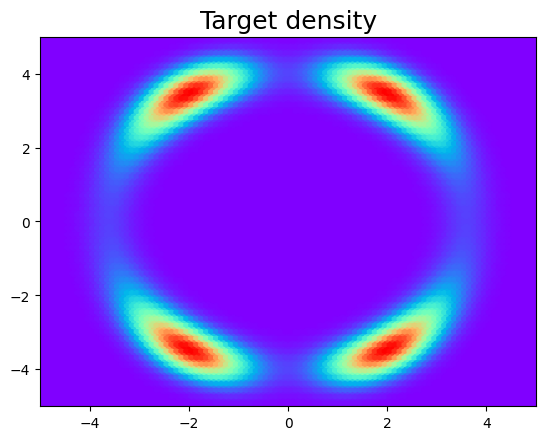

In [16]:
def density_ring_log(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1**2 + z2**2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return -u


# Plot it
x = np.linspace(-5, 5, 1000)
z_target = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z_target = np.reshape(z_target, [z_target.shape[0] * z_target.shape[1], -1])
z_density = density_ring_log(torch.asarray(z_target)).exp().numpy().squeeze()


def plot_target(ax: plt.Axes | None = None):
    ax = ax or plt.gca()
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.hexbin(
        z_target[:, 0],
        z_target[:, 1],
        C=z_density,
        cmap="rainbow",
        extent=(-5, 5, -5, 5),
    )
    ax.set_title("Target density", fontsize=18)


plot_target()

Expected results:

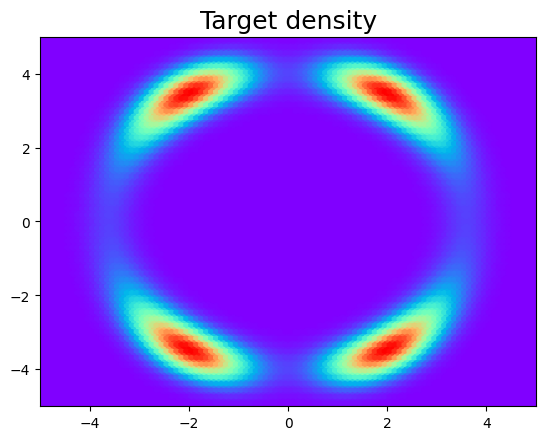



Now to approximate such a complicated density, we will need to chain multiple planar flows and optimize their parameters to find a suitable approximation. We can do exactly that like in the following (you can see that we start by a simple normal density and perform 16 successive planar flows).

We define the class `NormalizingFlow`, which inherits from `nn.Module`. 

In [17]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, dim: int, flow_length: int):
        super().__init__()
        self.bijectors = nn.ModuleList(
            [PlanarFlowModule(dim) for _ in range(flow_length)]
        )

    def forward(self, z: Tensor) -> tuple[Tensor, Tensor]:
        """Forward transformation of the normalizing flow
        Args:
            z: input tensor of shape (batch_size, dim)
        Returns:
            z: transformed tensor of shape (batch_size, dim)
            log_dets: log absolute determinants of the Jacobians, shape (batch_size, flow_length)
        """
        log_dets = []
        # Applies series of flows
        for flow in self.bijectors:
            z, log_det = flow.forward(z)
            log_dets.append(log_det)
        return z, torch.stack(log_dets, dim=-1)

Now the only missing ingredient is the loss function. Define the loss function below according to equation (15) in [1]:

$$ \mathcal{L}_n =
\frac{1}{d\cdot n}
\sum_{j=1}^n \bigg(- \sum_{i=1}^{k} \log \left|\det\frac{\partial f_i}{\partial\mathbf{z}^{(j)}_{i-1}}\right| - \log q_k(\mathbf{z}_k^{(j)}) \bigg)
$$

We additionally normalize by the dimension $d$ the loss in bits per dimension.
Note, that this requires the ability to evaluate the likelihood $q_k(z_k)$ for a sample $z_k$. Here, this is possible, in practice with real data, it is usually not. See the end of the notebook for more information.

In [19]:
def loss(target_d, z0, zk, log_jacobians, eps=1e-9):
    """Computes the loss function for normalizing flows
    Args:
        target_d: target log density function,
            i.e., log(q_k(.)),
            takes tensor of shape (batch_size, dim) and returns tensor of shape (batch_size,)
        z0: initial samples from base distribution, shape (batch_size, dim)
        zk: transformed samples after normalizing flow, shape (batch_size, dim)
        log_jacobians: log-abs-det jacobians of all layers, shape (batch_size, num_layers)
    """
    ### START CODE HERE ###
    n, d = zk.shape
    
    sum_log_jacobians = log_jacobians.sum(dim=-1) 
    
    log_qk = target_d(zk)  
    
    loss_per_sample = -sum_log_jacobians - log_qk 
    loss_value = loss_per_sample.mean() / d
    
    return loss_value
    ### END CODE HERE ###

## Part VII. Training and Sampling

Implement a sampling and a training function below. The sampling function should:

1. Draw `n_samples` samples $z_0$ from the `base` distribution.
2. Compute $z_k$ using the `flow` model. 
3. Plot $z_k$ with `cmap=rainbow` in $[-5, 5] \times [-5,5]$

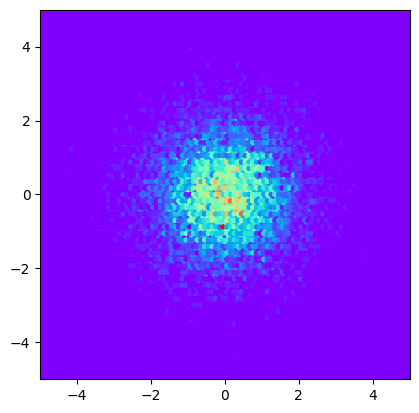

In [20]:
@torch.inference_mode()
def sample_and_plot(flow, base, n_samples=100_000, ax: plt.Axes | None = None):
    """Samples from the normalizing flow and plots the results
    Args:
        flow: normalizing flow model
        base: base distribution to sample from,
           allowing to draw samples of shape (n_samples, dim)
           with `base.sample((n_samples,))`
        n_samples: number of samples to draw
        ax: matplotlib Axes to plot on (optional)
    """
    ax = ax or plt.gca()
    # Use ax.hexbin, not plt.hexbin
    ### START CODE HERE ###
    # 1. Draw n_samples samples z0 from the base distribution
    z0 = base.sample((n_samples,))
    
    # 2. Compute zk using the flow model
    zk, _ = flow(z0)
    
    # 3. Plot zk with cmap=rainbow in [-5, 5] x [-5, 5]
    zk_np = zk.numpy()
    ax.hexbin(zk_np[:, 0], zk_np[:, 1], cmap='rainbow', extent=[-5, 5, -5, 5])
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ### END CODE HERE ###


sample_and_plot(
    NormalizingFlow(2, 2),
    distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)),
    10_000,
);

Expected results:

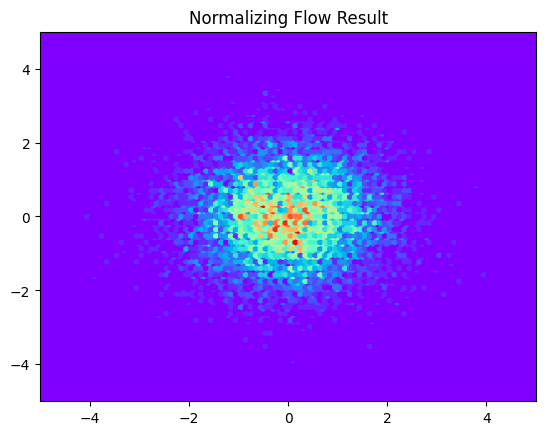



For training, we introduce a learning rate scheduler. It enables us to change the learning rate during training, for example linearly or exponentially decay it. 

Have a look at the [torch.optim](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) doc to learn how to use a scheduler. 

The training function should:

1. Plot the target distribution with `cmap=rainbow`.
2. Iterate `n_steps` over a training loop by:
    1. Draw 512 samples from the `base` distribution.
    2. Compute $z_K$ and log-jacobians using the `flow` model.
    3. Compute the loss. 
    4. Update the model with the `optimizer`.
    6. Update the `scheduler` to adjust the learning rate.

In [ ]:
from IPython.display import display
from contextlib import nullcontext


class TrainingPlotter:
    def __init__(self, plot_fn, plot_tgt_fn=None, height=2, width=2):
        self.plot_fn = plot_fn
        self.plot_tgt_fn = plot_tgt_fn
        self.height = height
        self.width = width

    def __enter__(self):
        if self.plot_tgt_fn is None:
            fig, ax = plt.subplots(ncols=1, figsize=(self.width, self.height))
            ax = [ax]
        else:
            fig, ax = plt.subplots(ncols=2, figsize=(2 * self.width + 1, self.height), sharey=True)
        self.fig = fig
        self.ax = ax
        self.dh = display(fig, display_id=True)
        return self

    def __call__(self, flow, base):
        for ax in self.ax:
            ax.clear()
        self.plot_fn(flow, base, ax=self.ax[0])
        if self.plot_tgt_fn is not None:
            self.plot_tgt_fn(ax=self.ax[1])
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        self.dh.update(self.fig)

    def __exit__(self, exc_type, exc_val, exc_tb):
        plt.close(self.fig)


def train(
    flow,
    base,
    target_d,
    *,
    steps,
    optimizer,
    scheduler,
    plot_every_n=1000,
    plotter=None,
):
    """Trains the normalizing flow to approximate the target density
    Args:
        flow: normalizing flow model
        base: base distribution to sample from
        target_d: target log density function
        steps: number of training steps
        optimizer: optimizer to use
        scheduler: learning rate scheduler
    """
    device = next(flow.parameters()).device
    plotter = plotter if plotter is not None else nullcontext()
    # Main optimization loop
    with trange(steps) as pbar, plotter as plt_ctx:
        for it in pbar:
            ### START CODE HERE ###
            z0 = base.sample((512,)).to(device)
            
            zk, log_jacobians = flow(z0)
            
            loss_v = loss(target_d, z0, zk, log_jacobians)
            
            optimizer.zero_grad()
            loss_v.backward()
            optimizer.step()
            
            # 5. Update the scheduler to adjust the learning rate
            scheduler.step()
            ### END CODE HERE ###

            pbar.set_postfix(
                lr=f"{optimizer.param_groups[0]['lr']:.3g}",
                loss=f"{loss_v.item():4.2f}",
            )
            if plt_ctx is not None and it % plot_every_n == 0:
                plotter(flow, base)

We can now perform optimization as usual by defining an optimizer, the parameters it will act on and the learning rate scheduler. 

* Define a flow model with `dim=2` and `flow_length=16`.
* Define an Adam optimizer with `lr=2e-3`.
* Define a scheduler `optim.lr_scheduler.ExponentialLR` with gamma $0.9999$.
* Define a 2-dimensional standard normal distribution as a base distribution.
* Run the training for 10001 steps.

  0%|          | 0/10001 [00:00<?, ?it/s]

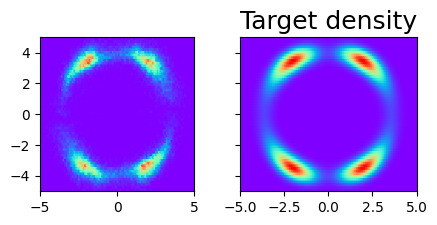

In [22]:
# Create normalizing flow
flow = NormalizingFlow(dim=2, flow_length=16)

# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=2e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

steps = 10001
base = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))

plotter = TrainingPlotter(sample_and_plot, plot_target)
train(
    flow,
    base,
    density_ring_log,
    steps=steps,
    optimizer=optimizer,
    scheduler=scheduler,
    plotter=plotter,
)

You can check your results with the plots below:

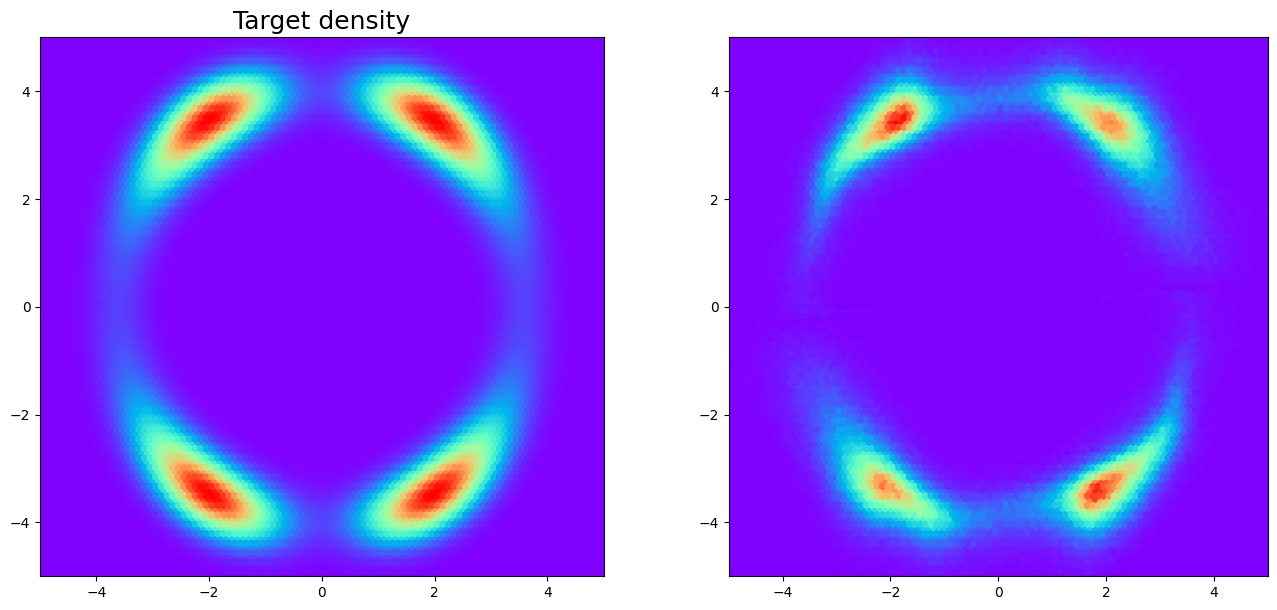

In [23]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
plot_target(ax1)
sample_and_plot(flow, base, n_samples=1_000_000, ax=ax2);

Expected results:

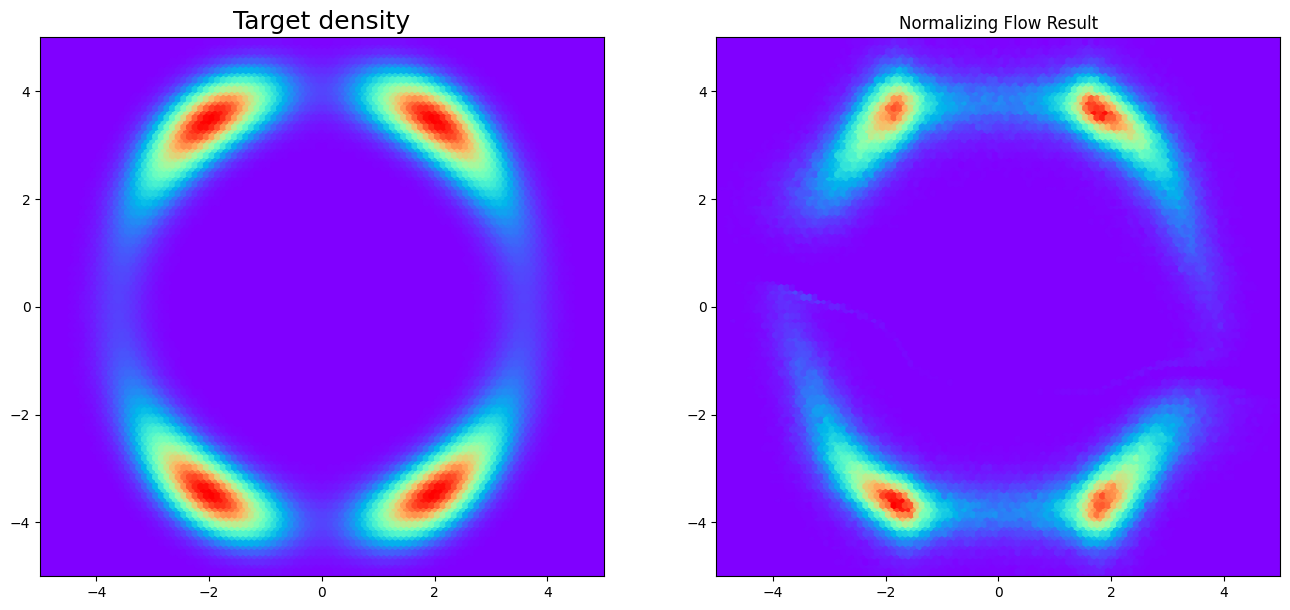



## Part VIII. Normalizing Flow Models in Practice

Planar flows are a nice introduction to the topic and help to illustrate core concepts of normalizing flows, such as chaining invertible operations into each other, using the change of variables formula and the inverse function theorem applied to a product of determinants. 

A core difference to the training of NF models on real data is the training objective. This is because real target distributions are usually intractable, meaning their density function is unknown, we can only draw samples from it (sometimes a limited amount). Say, we have a dataset of images and want to learn the underlying distribution $p(x)$, in order to generate new images and/or compute the likelihood of images. 

Recall, that

$$
\log q_k(\mathbf{z}_k) = \log q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \log \left|\det\frac{\partial f_i}{\partial\mathbf{z}_{i-1}}\right| 
$$

Now, given a NF model (i.e. a chain of invertible operations with easy to compute determinant of the jacobian of the inverse), we want to optimize it in such a way, that $z_k \approx x$. This is accomplished by maximizing the likelihood of samples from $p(x)$ under the model, by using the above equation to compute the likelihood $p(z_k)$.

For planar flows, we have only used the **generative direction** of the normalizing flow model, where a sample from the base distribution is transformed to a sample from the target distribution. In practice, training a normalizing flow model requires computation in the **normalizing direction**, i.e. transforming a sample from the target distribution to one from the base distribution (which is usually a normal distribution).

Given a standard normal gaussian as base distribution, the training procedure looks as follows:

1. Draw a sample $x \sim p(x)$.
2. Apply the NF model in the **normalizing direction** (i.e. inverted) to transform the sample $x$ to a sample $z_0$ from the base distribution. 
3. In each intermediate layer (invertible operation), compute the log-determinant of the Jacobian. 
4. Compute the likelihood of the resulting $z_0$, under the base distribution (i.e. $q_0(z_0)$.
5. Compute the likelihood of the initial sample $p(x)$ with the formula above.
6. Maximize this likelihood.

### Further Reading

If you want to check out some more powerful NF models, have a look at:

* [Glow: Generative Flow with Invertible 1x1 Convolutions](https://arxiv.org/abs/1807.03039)
* [Density estimation using Real NVP](https://arxiv.org/abs/1605.08803)

or further explanatory reading
* [Flow-based Deep Generative Models blog](https://lilianweng.github.io/posts/2018-10-13-flow-models/)
* [Normalizing Flows: An Introduction and Review of Current Methods](https://arxiv.org/abs/1908.09257)

## Part IX. Implementing Affine Coupling Layers

While the planar flow layers are (under mild conditions) invertible, their inverse has no closed form.
Therefore, we cannot easily use them in the normalizing direction, which is required for training a generative model on real data.

Dinh. et al [4] introduced *affine coupling layers*, which
- have a closed form inverse,
- have a computationally efficient determinant of the Jacobian, and
- can be stacked to form deep normalizing flow models.

The idea is as follows:
Split the input $\mathbf{z}$ into *active* and *passive* parts, $\mathbf{z} = [\mathbf{z}_a, \mathbf{z}_p]$.

The passive part $\mathbf{z}_p$ remains unchanged, but is used to compute scale and shift parameters for the active part $\mathbf{z}_a$ via neural networks $s(\cdot)$ and $t(\cdot)$.
The active part is then transformed as follows:
$$
\mathbf{z}_a' = \mathbf{z}_a \odot \exp(s(\mathbf{z}_p)) + t(\mathbf{z}_p)
\tag{8}
$$
The output $\mathbf{z}'$ is then obtained by concatenating the transformed active part $\mathbf{z}_a'$ and the unchanged passive part $\mathbf{z}_p$.
The Jacobian of this transformation is triangular:
$$
\frac{\partial \mathbf{z}'}{\partial \mathbf{z}} =
\begin{bmatrix}
\text{diag}(\exp(s(\mathbf{z}_p))) & * \\
0 & I
\end{bmatrix},
$$
so that the determinant of the Jacobian is simply given by the product of the diagonal elements, which can be computed in linear time.

The NN is initialized such that $s(\cdot)$ and $t(\cdot)$ output zeros at the beginning of training, so that the initial transformation is close to the identity.
Since the passive part remains unchanged, the inverse transformation is given by
$$
\mathbf{z}_a = (\mathbf{z}_a' - t(\mathbf{z}_p)) \odot \exp(-s(\mathbf{z}_p))
\tag{9}
$$

Of course, we need to change what is active and passive in every layer to ensure that all dimensions are transformed.
We will just swap the active and passive parts in every layer, but more sophisticated schemes, like checkerboard patterns or random permutations, are possible.

Implement the `AffineCouplingLayer` class below.

In [42]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_dim, even=True):
        """
        Affine Coupling Layer as in eq. 8 and 9
        Args:
            dim: input dimension (must be even)
            hidden_dim: hidden dimension of the NN
            even: Determines which half is active and which is passive
        """
        super().__init__()
        # output of nn is [log_s, t] stacked along last dimension
        self.nn = nn.Sequential(
            nn.Linear(dim // 2, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, dim)
        )
        self.init_parameters()
        self.even = even

    def init_parameters(self):
        for p in self.parameters():
            p.data.fill_(0)

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """Forward transformation (normalizing direction)
        Args:
            x: input tensor of shape (batch_size, dim)
        Returns:
            y: transformed tensor of shape (batch_size, dim) according to eq. 8
            log_abs_det: log absolute determinant of the Jacobian, shape (batch_size,)
        """
        ### START CODE HERE ###
        x1, x2 = torch.chunk(x, chunks=2, dim=1)
        if self.even:
            h = self.nn(x1)
            log_s, t = torch.chunk(h, chunks=2, dim=1)
            s = torch.exp(log_s)
            y1 = x1
            y2 = s * x2 + t
            log_abs_det = torch.sum(log_s, dim=1)
            y = torch.cat([y1, y2], dim=1)
            return y, log_abs_det
        else:
            h = self.nn(x2)
            log_s, t = torch.chunk(h, chunks=2, dim=1)
            s = torch.exp(log_s)
            y1 = s * x1 + t
            y2 = x2
            log_abs_det = torch.sum(log_s, dim=1)
            y = torch.cat([y1, y2], dim=1)
            return y, log_abs_det
        ### END CODE HERE ###

    def inverse(self, y: Tensor) -> Tensor:
        """Inverse transformation (generative direction)
        Args:
               y: input tensor of shape (batch_size, dim)
           Returns:
               x: transformed tensor of shape (batch_size, dim) according to eq. 9
        """
        # We don't need the log-det in the inverse direction
        ### START CODE HERE ###
        y1, y2 = torch.chunk(y, chunks=2, dim=1)
        if self.even:
            h = self.nn(y1)
            log_s, t = torch.chunk(h, chunks=2, dim=1)
            s = torch.exp(log_s)
            x1 = y1
            x2 = (y2 - t) / s
            x = torch.cat([x1, x2], dim=1)
            return x
        else:
            h = self.nn(y2)
            log_s, t = torch.chunk(h, chunks=2, dim=1)
            s = torch.exp(log_s)
            x1 = (y1 - t) / s
            x2 = y2
            x = torch.cat([x1, x2], dim=1)
            return x
        ### END CODE HERE ###


# Test the layer
test_layers = []
for even in [True, False]:
    test_layer = AffineCouplingLayer(dim=8, hidden_dim=16, even=even)
    x = torch.randn(2, 8)
    y, log_det = test_layer.forward(x)
    # Weights are initialized to zero
    assert torch.allclose(x, y), "Unintialized weights should lead to identity mapping"
    assert torch.allclose(log_det, torch.zeros(2)), (
        "Unintialized weights should lead to zero log-det"
    )
    for p in test_layer.parameters():
        p.data.uniform_(-0.5, 0.5)
    y = test_layer.forward(x)[0]
    assert torch.isclose(y, x).sum() == x.numel() // 2, (
        "After random init, half of output should differ from input"
    )
    x_recon = test_layer.inverse(y)
    assert torch.allclose(x, x_recon), "Inverse should recover original input"

Since our data (images) is in the range [0, 1], we will use the logit transform as a preprocessing step to map the data to the real line.
This layer also normalizes the data to have zero mean and unit variance.

Try to check that the math works out!

In [43]:
class SigmoidNormalizeLayer(nn.Module):
    alpha = 1e-3
    mean = -4.7679
    std = 3.0772

    def forward(self, x):
        # map [0,1] to [alpha, 1-alpha] first to avoid numerical issues
        x = x * (1 - 2 * self.alpha) + self.alpha
        y = x.log() - (1 - x).log()
        y = (y - self.mean) / self.std
        # No parameters, so we don't need the true log_det
        log_det = x.new_zeros(x.shape[0])
        return y, log_det

    def inverse(self, y):
        y = y * self.std + self.mean
        x = y.sigmoid()
        x = (x - self.alpha) / (1 - 2 * self.alpha)
        return x

test_layer = SigmoidNormalizeLayer()
x = torch.rand(2, 8)
y, _ = test_layer(x)
x_recon = test_layer.inverse(y)
assert torch.allclose(x, x_recon)

Finally we assemble everything together.

In [44]:
class NormalizingCouplingFlow(NormalizingFlow):
    def __init__(self, dim: int, flow_length: int, hidden_dim: int | None = None):
        nn.Module.__init__(self)
        self.dim = dim
        hidden_dim = hidden_dim or 2 * dim
        self.bijectors = nn.ModuleList(
            [SigmoidNormalizeLayer()]
            + [
                AffineCouplingLayer(dim=dim, hidden_dim=hidden_dim, even=i % 2 == 0)
                for i in range(flow_length)
            ]
        )

    @torch.inference_mode()
    def inverse(self, z):
        for layer in reversed(self.bijectors):
            z = layer.inverse(z)
        return z

## Part X. Training on MNIST (Optional)

If you want, you can now train the coupling layer based normalizing flow model on the MNIST dataset.
We provide a plotting function and sampler to work with the previous `train` function.

In [45]:
# Auxiliary code for sampling and plotting

from torchvision.datasets import MNIST
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


@torch.inference_mode()
def plot_mnist(flow, base=None, nrows=4, ncols=1, ax=None):
    width = int(flow.dim**0.5)
    assert width**2 == flow.dim
    nsamples = nrows * ncols
    ax = ax or plt.gca()
    device = next(flow.parameters()).device
    inp = torch.randn(nsamples, flow.dim, device=device)
    out = flow.inverse(inp)
    out = out.view(-1, 1, width, width)
    out = make_grid(1 - out, normalize=True, nrow=nrows)
    out = out.permute(1, 2, 0).cpu().numpy()
    ax.axis("off")
    ax.imshow(out)


class MnistSampler:
    def __init__(self, batch_size: int, size: int = 28):
        transform = T.Compose([T.Resize(size), T.ToTensor(), T.Lambda(Tensor.flatten)])
        self.dataset = MNIST("data", download=True, transform=transform)
        self.batch_size = batch_size
        self.iter = self.batch_iter()

    def batch_iter(self):
        loader = DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=8,
        )
        while True:
            for x, _ in loader:
                yield x

    def sample(self, _):
        return next(self.iter)

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 6048445.11it/s]



Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 177247.71it/s]



Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2223385.39it/s]



Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1515434.63it/s]



Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/20001 [00:00<?, ?it/s]

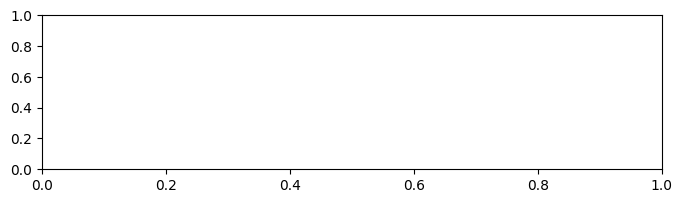

KeyboardInterrupt: 

In [46]:
# You can downsize the resolution or reduce flow length for faster training
img_size = 28
flow_length = 16

# Create normalizing flow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim = img_size**2
flow = NormalizingCouplingFlow(dim, flow_length=flow_length).to(device)

# Create optimizer algorithm
optimizer = optim.AdamW(flow.parameters())

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
steps = 20001

sampler = MnistSampler(batch_size=512, size=img_size)
target_d = distrib.MultivariateNormal(
    torch.zeros(dim, device=device), torch.eye(dim, device=device)
)

plotter = TrainingPlotter(plot_fn=plot_mnist, width=8)
train(
    flow,
    sampler,
    target_d.log_prob,
    steps=steps,
    optimizer=optimizer,
    scheduler=scheduler,
    plotter=plotter,
)

In [ ]:
plt.figure(figsize=(16, 16))
plot_mnist(flow, nrows=10, ncols=10)

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Germain, Mathieu, et al. "Made: masked autoencoder for distribution estimation." International Conference on Machine Learning. 2015.

[4] Dinh, et al. "NICE: Non-linear Independent Components Estimation", _arXiv preprint arXiv:1410.8516_ (2014). [link](https://arxiv.org/abs/1410.8516)

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  
https://github.com/bayesiains/nflows